# DTM Plane

In [26]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import choice
from scipy import signal
from pickle import load,dump
import math
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

## Analysis

<AxesSubplot:title={'center':'Subjects/Nikhil/computed_Hammer.csv'}>

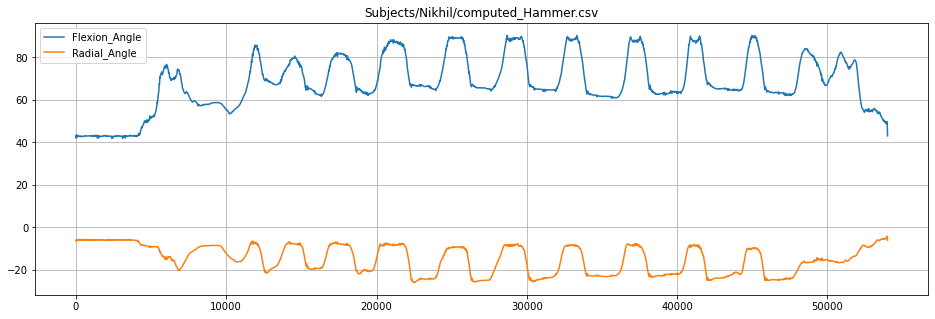

In [65]:
file = 'Subjects/Nikhil/computed_Hammer.csv'
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
angle_lables = ['Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle']
df = pd.read_csv(file,index_col=0)#[26000:26500]
df[angle_lables[1:3]].plot(figsize=(16,5),title=file,grid=True)

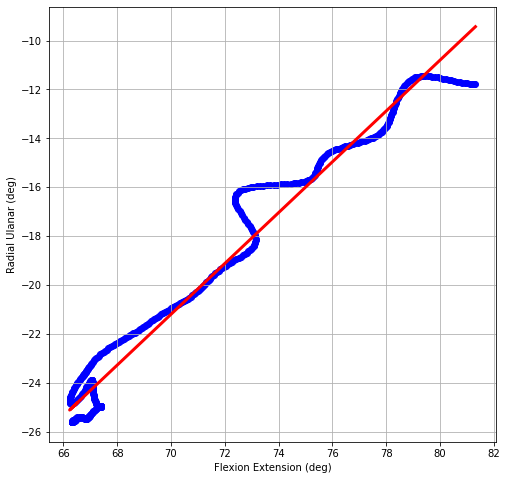

In [61]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


flexex_angle = df['Flexion_Angle']
radial_angle = df['Radial_Angle']

flexex_angle = np.array(flexex_angle).reshape((flexex_angle.shape[0],1))
radial_angle = np.array(radial_angle).reshape((flexex_angle.shape[0],1))

regr = linear_model.LinearRegression()
regr.fit(flexex_angle,radial_angle)
radial_pred = regr.predict(flexex_angle)
plt.figure(figsize=(8,8))
plt.scatter(flexex_angle, radial_angle,  color='blue')
plt.plot(flexex_angle, radial_pred, color='red', linewidth=3)
plt.grid()
plt.xlabel('Flexion Extension (deg)')
plt.ylabel('Radial Ulanar (deg)')
plt.show()

In [62]:
from math import atan, degrees
slope = regr.coef_
intercept = regr.intercept_
angle = atan(slope)
degrees(angle)

46.12115016151073

In [66]:
from statistics import variance

In [68]:
flexex_angle = df['Flexion_Angle']
radial_angle = df['Radial_Angle']
flexex_angle = np.array(flexex_angle).reshape((flexex_angle.shape[0],1))
radial_angle = np.array(radial_angle).reshape((flexex_angle.shape[0],1))
flexex_var = variance(flexex_angle.reshape((flexex_angle.shape[0],)))
radial_var = variance(radial_angle.reshape((radial_angle.shape[0],)))

In [69]:
dtm_var = 1/((1/flexex_var) + (1/radial_var))
dtm_angle = dtm_var*(flexex_angle*((1/flexex_var)) + radial_angle*((1/radial_var)))

In [70]:
df['DTM_Angle'] = dtm_angle

<AxesSubplot:>

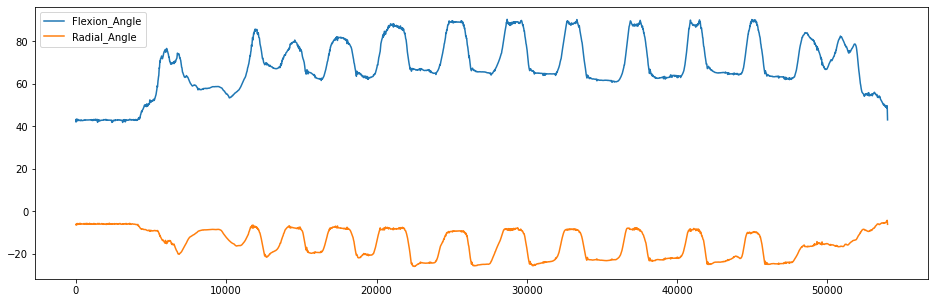

In [74]:
df[['Flexion_Angle','Radial_Angle']].plot(figsize=(16,5))

<AxesSubplot:>

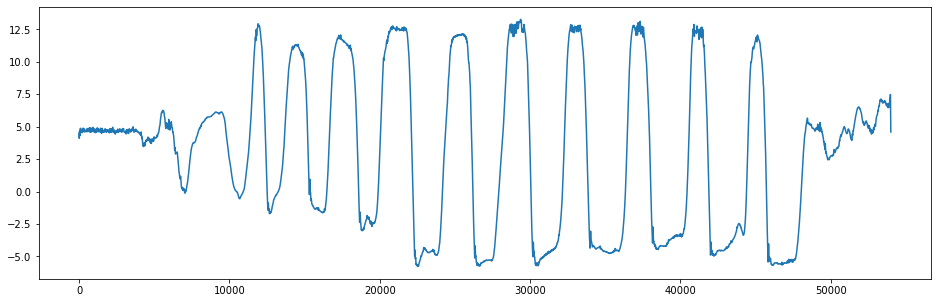

In [75]:
df['DTM_Angle'].plot(figsize=(16,5))